In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import scipy.stats as stats
from arch import arch_model
import statsmodels.api as sm

from pmdarima.model_selection import train_test_split
from scipy.stats import chi2, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

In [2]:
df = yf.Ticker("SPY").history(start="2010-01-01", end="2023-07-01")
df.index = pd.to_datetime(df.index)
price = df[['Close']]

In [3]:
price.head()

,Close
Date,
2010-01-04 00:00:00-05:00,87.791786
2010-01-05 00:00:00-05:00,88.024170
2010-01-06 00:00:00-05:00,88.086159
2010-01-07 00:00:00-05:00,88.458000
2010-01-08 00:00:00-05:00,88.752350


<h3> Plot SPY Daily Time Series </h3>

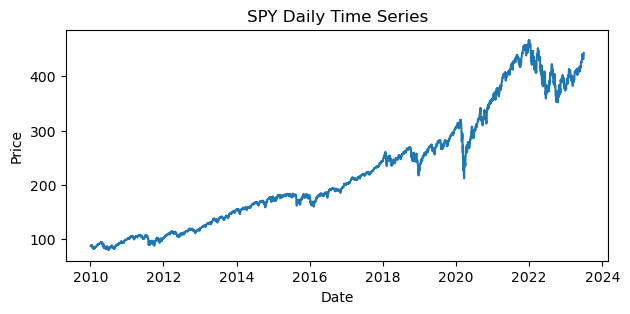

In [4]:
# Plot time series data
plt.figure(figsize=(7, 3))
plt.plot(price)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('SPY Daily Time Series')
plt.show()

<h3> SPY Log Returns </h3>

In [5]:
SPY_log_returns = np.log(price / price.shift(1)).dropna()*100
SPY_log_returns.head()

,Close
Date,
2010-01-05 00:00:00-05:00,0.264349
2010-01-06 00:00:00-05:00,0.070398
2010-01-07 00:00:00-05:00,0.421245
2010-01-08 00:00:00-05:00,0.332204
2010-01-11 00:00:00-05:00,0.139549


<h3> Plot SPY Prices & Returns </h3>

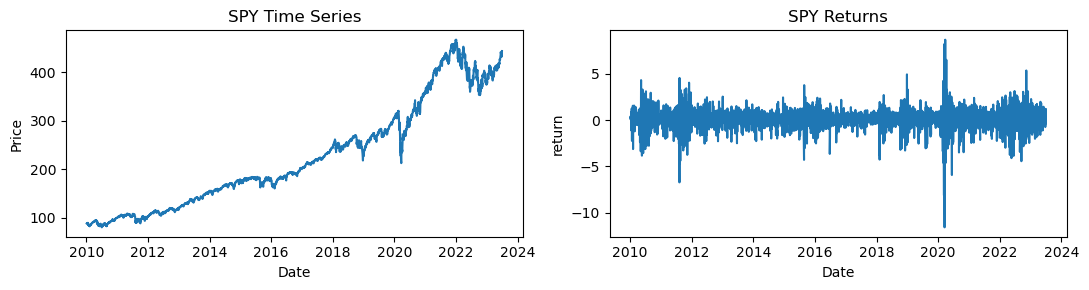

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(11, 3))

# Plot 'SPY' 
axes[0].plot(price)
axes[0].set_title('SPY Time Series')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Price')

# Plot 'SPY' returns
axes[1].plot(SPY_log_returns)
axes[1].set_title('SPY Returns')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('return')

plt.tight_layout()
plt.show() 

<h3> Plot ACF & PACF </h3>

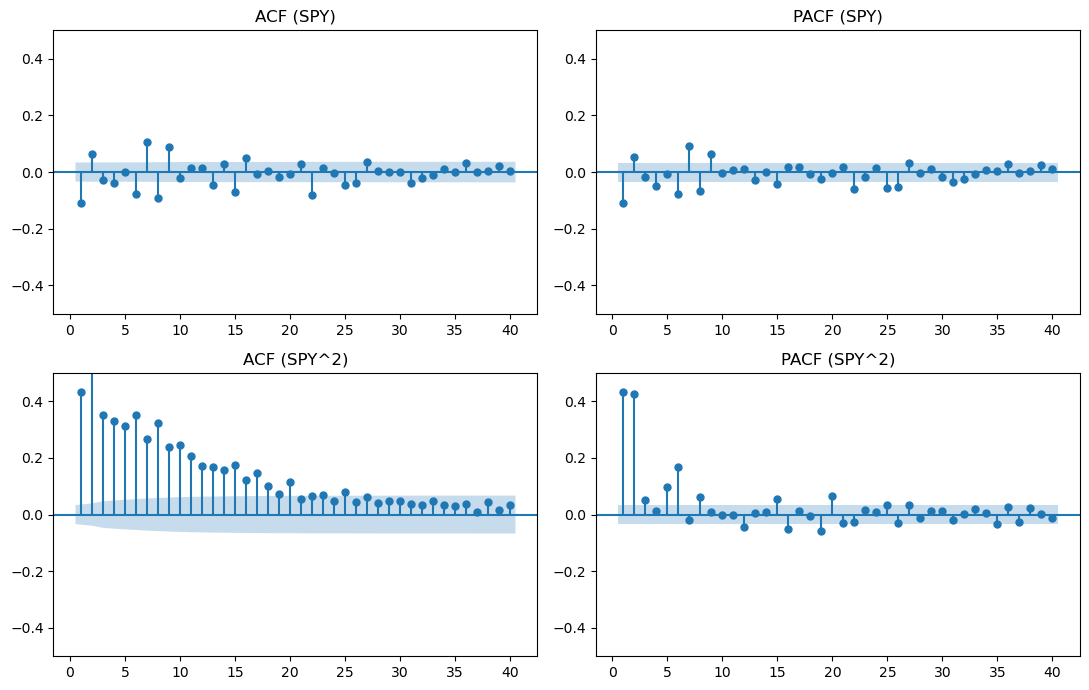

In [7]:
fig, axes = plt.subplots(2, 2, figsize=(11, 7))

# Plot ACF of 'SPY'
plot_acf(SPY_log_returns, lags=40, ax=axes[0,0], zero=False, title="ACF (SPY)")
axes[0,0].set_ylim(-0.5, 0.5)

# Plot PACF of 'SPY'
plot_pacf(SPY_log_returns, lags=40, ax=axes[0,1],zero=False, method='ywm', title="PACF (SPY)")
axes[0,1].set_ylim(-0.5, 0.5)

# Plot ACF of 'SPY^2'
plot_acf(SPY_log_returns**2, lags=40, ax=axes[1,0],zero=False, title="ACF (SPY^2)")
axes[1,0].set_ylim(-0.5, 0.5)

# Plot PACF of 'SPY^2'
plot_pacf(SPY_log_returns**2, lags=40, ax=axes[1,1],zero=False, method='ywm', title="PACF (SPY^2)")
axes[1,1].set_ylim(-0.5, 0.5)

plt.tight_layout()
plt.show()  

Marginally significant time dependence is present in the returns, while highly significant time dependence is apparent in the squared returns.

<h3> Fit GARCH(1,1) Model </h3>

In [41]:
y_train, y_test = train_test_split(SPY_log_returns,train_size=0.8)

In [47]:
# Fit GARCH(1,1) model
garch_model = arch_model(y_train, mean="Zero", vol="Garch", p=1, q=1).fit()
print(garch_model.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 15247.275942444487
Iteration:      2,   Func. Count:     15,   Neg. LLF: 5534.247434521154
Iteration:      3,   Func. Count:     21,   Neg. LLF: 5764.442306146031
Iteration:      4,   Func. Count:     26,   Neg. LLF: 3523.441427380906
Iteration:      5,   Func. Count:     31,   Neg. LLF: 3391.3917178899774
Iteration:      6,   Func. Count:     35,   Neg. LLF: 3391.3895129955526
Iteration:      7,   Func. Count:     39,   Neg. LLF: 3391.3895030452736
Iteration:      8,   Func. Count:     42,   Neg. LLF: 3391.389503046043
Optimization terminated successfully    (Exit mode 0)
            Current function value: 3391.3895030452736
            Iterations: 8
            Function evaluations: 42
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared

<h3> Residual Diagnostics </h3>

In [48]:
garch_standardized_residuals = (garch_model.resid / garch_model.conditional_volatility)

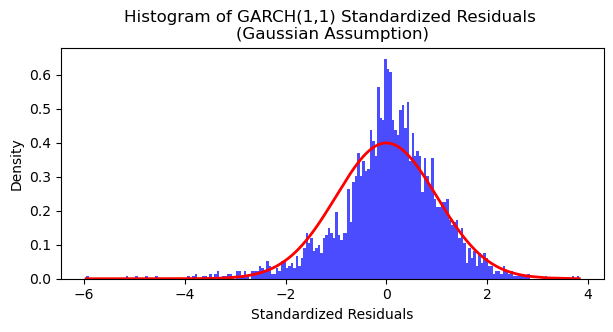

In [49]:
# Plot Histogram of Standardized Residuals
plt.figure(figsize=(7, 3))
hist0 = plt.hist(garch_standardized_residuals, bins=200, density=True, color='blue', alpha=0.7)
x_density = np.sort(garch_standardized_residuals)
y_density = stats.norm.pdf(x_density)
plt.plot(x_density, y_density, color='red', linewidth=2)
plt.title("Histogram of GARCH(1,1) Standardized Residuals \n(Gaussian Assumption)")
plt.xlabel("Standardized Residuals")
plt.ylabel("Density")
plt.show()

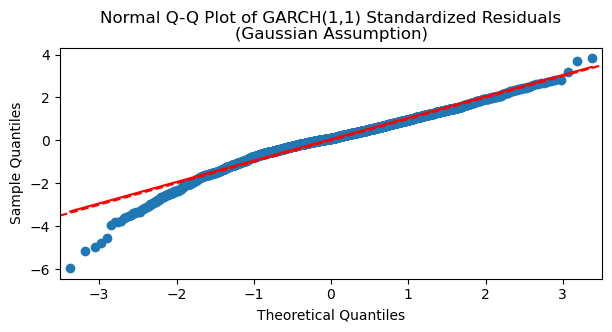

In [50]:
# Normal Q-Q Plot of Standardized Residuals
fig = sm.qqplot(garch_standardized_residuals, line='s', color='skyblue')
plt.title("Normal Q-Q Plot of GARCH(1,1) Standardized Residuals\n(Gaussian Assumption)")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")
fig.set_size_inches(7,3)
plt.axline((0,0), slope=1, color='red', linestyle='--')
plt.show()

<h3> Jarque Bera Test </h3>

We make an assumption in the GARCH(P,Q) model about the distribution of our errors: if the model is specified correctly, then the errors are normally distributed with mean 0 and constant variance. The Jarque-Bera test checks if the model errors are normally distributed. </br>
H₀: The data has a normal distribution. </br>
Hₐ: The data does not have a normal distribution.

In [51]:
# Perform Jarque-Bera test 
jb_test = jarque_bera(garch_standardized_residuals)
print("Jarque-Bera test statistic:", jb_test[0])
print("p-value:", jb_test[1])

Jarque-Bera test statistic: 761.1561596501734
p-value: 5.212427154778644e-166


The Jarque-Bera test shows us that we do not have standardized residuals that follow the normal distribution. 

<h3> Plot Fitted Daily Volatilities </h3>

In [52]:
# Extract the fitted volatility values
fitted_vol_garch = garch_model.conditional_volatility

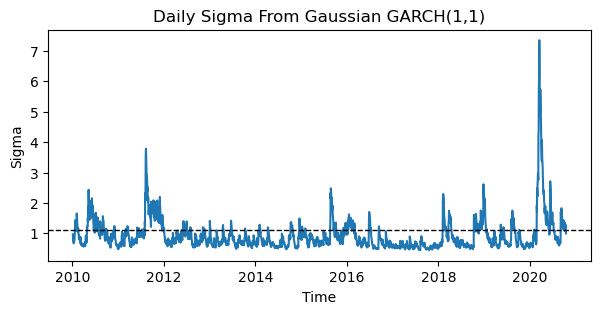

In [53]:
# Calculate the sample variance of the original data 'SPY_log_returns'
sample_variance = np.var(SPY_log_returns)

plt.figure(figsize=(7, 3))

plt.plot(fitted_vol_garch)
plt.axhline(y=np.sqrt(sample_variance)['Close'], color='black', linestyle='dashed', linewidth=1)
plt.title('Daily Sigma From Gaussian GARCH(1,1)')
plt.xlabel('Time')
plt.ylabel('Sigma')

plt.show()

<h3> Plot Fitted Annualized Volatilities / (Volatilities) </h3>

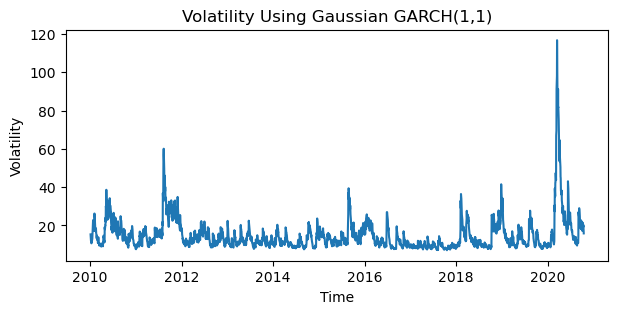

In [54]:
# Calculate annualized volatility
annualized_volatility_garch = np.sqrt(252) * garch_model.conditional_volatility

plt.figure(figsize=(7, 3))

plt.plot(annualized_volatility_garch)
plt.title("Volatility Using Gaussian GARCH(1,1)")
plt.xlabel("Time")
plt.ylabel("Volatility")

plt.show()

<h3> Forecasting Volatility </h3>

<h4> N-Step Ahead Forecast </h4>
We use these forecasts to extend the forecast of volatility to times t+1, t+2, …, t+n. We do not continually update Xₜ as time t increases, but rather limit our forecasts for all future dates to be made solely on the current date.

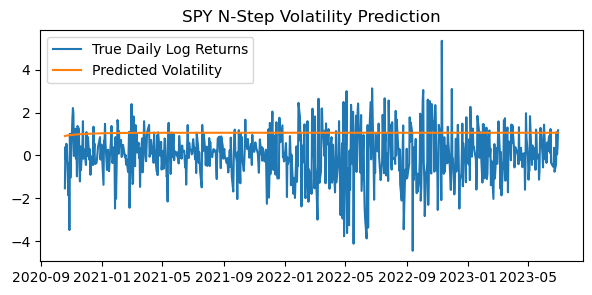

In [66]:
y_predicted = garch_model.forecast(horizon=y_test.shape[0], reindex=True)

plt.figure(figsize=(7, 3))

plt.plot(SPY_log_returns[-y_test.shape[0]:])
plt.plot(y_test.index, np.sqrt(y_predicted.variance.values[-1:][0]))
plt.title('SPY N-Step Volatility Prediction')
plt.legend(['True Daily Log Returns', 'Predicted Volatility'])
plt.show()

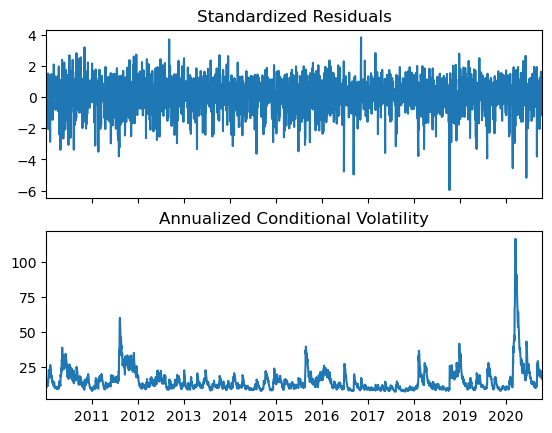

In [56]:
# Conditional volatility by model fitting
garch_model.plot(annualize="D")
plt.show()

<h4> One-Step Ahead Rolling Forecast </h4>
Another suitable and more pragmatic approach would be to only make one-step ahead predictions based on information up until time t and update the information to the model in real time as time t becomes time t+1, t+2, etc. More simply, with each passing day, we update Xₜ, Xₜ₊₁, Xₜ₊₂ with the actual, observed return from that day to model one time step ahead.

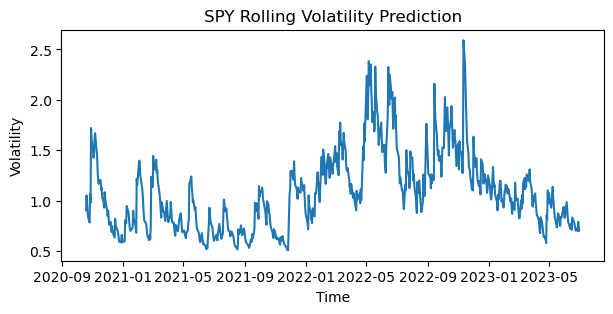

In [69]:
rolling_preds = []

for i in range(y_test.shape[0]):
    train = SPY_log_returns[:-(y_test.shape[0]-i)]
    model = arch_model(train, mean="Zero", vol="Garch", p=1, q=1).fit(disp='off')
    # One step ahead predictor
    pred = model.forecast(horizon=1, reindex=True)
    rolling_preds.append(np.sqrt(pred.variance.values[-1,:][0]))
    
rolling_preds = pd.Series(rolling_preds, index=y_test.index)


# Plot test data rolling volatility predictions
plt.figure(figsize=(7, 3))
plt.plot(rolling_preds)
plt.xlabel('Time')
plt.ylabel('Volatility')
plt.title('SPY Rolling Volatility Prediction')
plt.show()

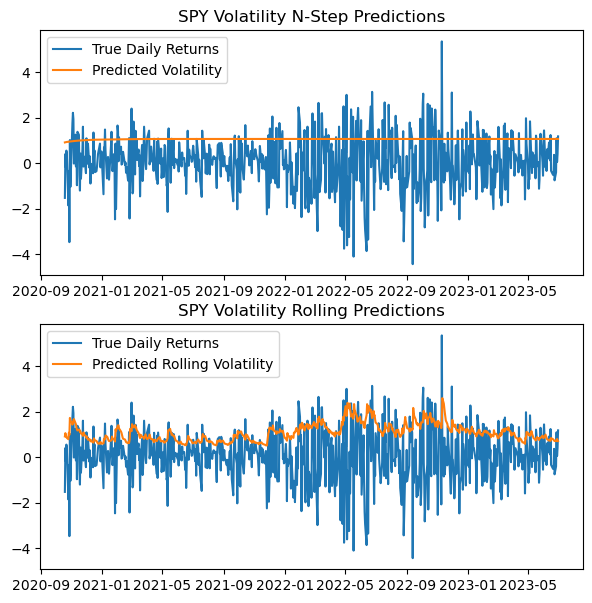

In [70]:
# Compare n-step-ahead and one-step-ahead rolling predictions
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 7))

ax1.plot(SPY_log_returns[-y_test.shape[0]:])
ax1.plot(y_test.index, np.sqrt(y_predicted.variance.values[-1:][0]))
ax1.set_title('SPY Volatility N-Step Predictions')
ax1.legend(['True Daily Returns', 'Predicted Volatility'])

ax2.plot(SPY_log_returns[-y_test.shape[0]:])
ax2.plot(y_test.index,rolling_preds)
ax2.set_title("SPY Volatility Rolling Predictions")
ax2.legend(['True Daily Returns', 'Predicted Rolling Volatility'])

plt.show()

The rolling volatility predictions has several strengths. It generates spikes in predicted volatility that line up with periods of actual higher variance of daily returns. We also notice its ability to predict volatility clustering — certain periods have lower variance followed by periods of large variance. Additionally, it appears to do well in forecasting these volatility spikes in advance of the swings in the true daily returns.